# 数据获取

通过sklearn提供的方法来获取数据，并拆分出训练集和测试集。

通过`split_mode`和`keep_meta`两个参数，控制切分策略和元数据保留策略。

In [170]:
import os,sys
import pickle
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from pprint import pprint
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
split_mode = 'TIME'
keep_meta = False

if keep_meta:
    removel = ()
else:
    removel = ('footers', 'quotes')
    
if split_mode == 'TIME':
    newsgroups_train = fetch_20newsgroups(data_home='.', subset='train', remove=removel)
    newsgroups_test = fetch_20newsgroups(data_home='.', subset='test', remove=removel)
elif split_mode == 'RANDOM':
    newsgroups_train = fetch_20newsgroups(data_home='.', subset='all', remove=removel)
else:
    raise Exception('Unknown split_mode: {}'.format(split_mode))
    
newsgroups_target_names = newsgroups_train.target_names

In [3]:
# 查看类别名称
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
def preprocess_data(doc):
    '''
    保留header中的Subject（标题）信息
    doc: 输入文档字符串
    return: header仅保留Subject的文档字符串
    '''
    sections = doc.split('\n\n')
    headers = sections[0].split('\n')
    for header in headers:
        if header.startswith('Subject:'):
            return '\n\n'.join([header] + sections[1:])

In [5]:
# 检查数据内容
print('category: {}'.format(newsgroups_target_names[newsgroups_train.target[0]]))
print('==============')
print(newsgroups_train.data[0])

category: rec.autos
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


## 数据分割

In [6]:
if split_mode == 'TIME':
    # 先划分训练集和测试集
    X_train, y_train = [preprocess_data(i) for i in newsgroups_train.data], newsgroups_train.target
    X_test, y_test = [preprocess_data(i) for i in newsgroups_test.data], newsgroups_test.target

    # 训练集进一步划分为训练集和验证集
    X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
elif split_mode == 'RANDOM':
    X_train, y_train = [preprocess_data(i) for i in newsgroups_train.data], newsgroups_train.target
    
    # 先划分训练集和测试集，随机划分时，训练集保留40%，使得训练集大小与按时间分隔时近似，方便比较
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=0, stratify=y_train)
    # 训练集进一步划分为训练集和验证集
    X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
else:
    raise Exception('Unknown split_mode: {}'.format(split_mode))

In [7]:
print('train size: {}'.format(len(X_train)))
print('train dev size: {}'.format(len(X_train_dev)))
print('val size: {}'.format(len(X_val)))
print('test size: {}'.format(len(X_test)))

train size: 11314
train dev size: 9051
val size: 2263
test size: 7532


In [8]:
# 查看经过处理过的数据
print(X_train[0])

Subject: WHAT car is this!?

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


# 数据探索

首先检查训练集、验证集和测试集类别分布情况，看数据在类别上的分布是否有倾斜。

In [9]:
def label_distributation(data, title):
    '''
    展示数据类别分布直方图
    data: pandas DataFrame，包含catid，数值型的分类标签
    '''
    label_dist = data['catid'].value_counts().sort_index().rename(dict([(i, cid) for i, cid in enumerate(newsgroups_target_names)]))
    label_dist.plot.bar(title=title, figsize=(10,5))

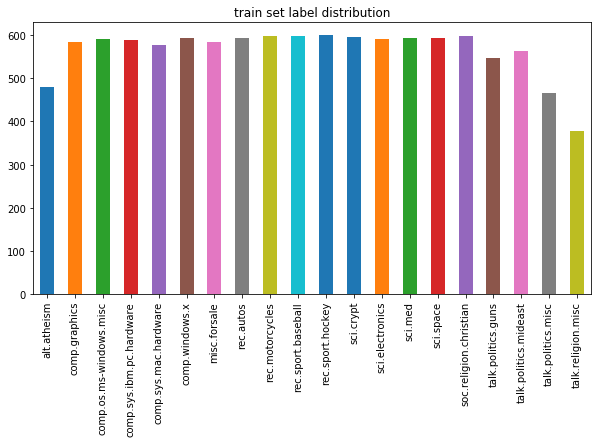

In [10]:
label_distributation(pd.DataFrame(data={'catid': y_train}), 'train set label distribution')

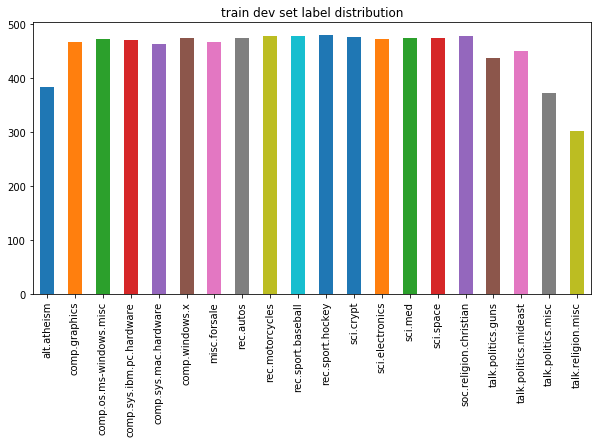

In [11]:
label_distributation(pd.DataFrame(data={'catid': y_train_dev}), 'train dev set label distribution')

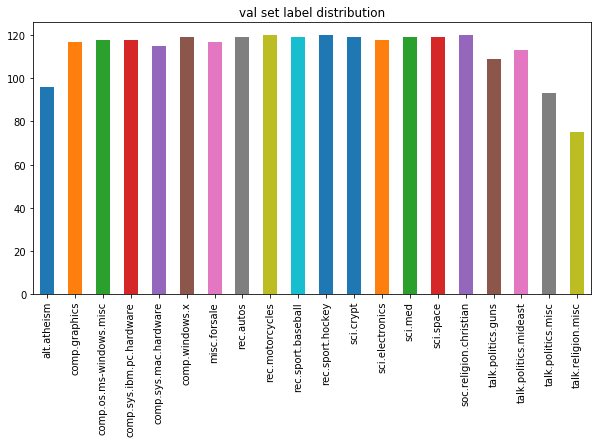

In [12]:
label_distributation(pd.DataFrame(data={'catid': y_val}), 'val set label distribution')

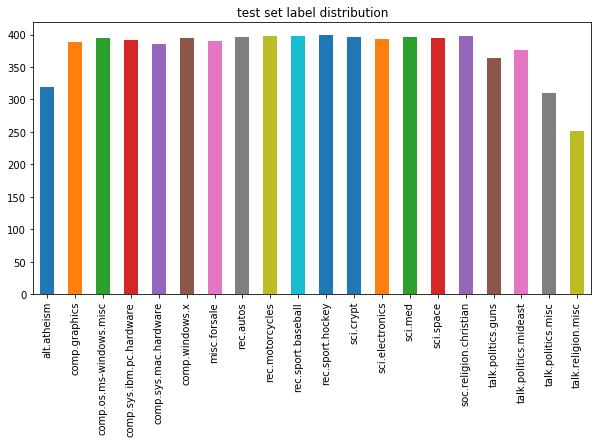

In [13]:
label_distributation(pd.DataFrame(data={'catid': y_test}), 'test set label distribution')

从上面几张图可以看到，训练集、验证集和测试集的数据在各个类别的分布比较均匀，只有一个类别`talk.religion.misc`数据量略小，预计不会对模型的指标有太大影响。

绘制训练集文档包含词数和字符数的直方图。

In [14]:
doc_word_count = []
doc_char_count = []
for i in X_train:
    doc_word_count.append(len(i.split()))
    doc_char_count.append(len(i))

def describe_data(data_name, data):
    print('{} min: {}'.format(data_name, np.min(data)))
    print('{} max: {}'.format(data_name, np.max(data)))
    print('{} 25 percent: {}'.format(data_name, np.percentile(data, 25)))
    print('{} 50 percent: {}'.format(data_name, np.percentile(data, 50)))
    print('{} 90 percent: {}'.format(data_name, np.percentile(data, 90)))
    print('{} 95 percent: {}'.format(data_name, np.percentile(data, 95)))
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=50)
    plt.title('{} distribution'.format(data_name))
    plt.xlabel(data_name)
    plt.ylabel('doc num')
    plt.show()

artical word count min: 2
artical word count max: 11776
artical word count 25 percent: 44.0
artical word count 50 percent: 88.0
artical word count 90 percent: 339.7000000000007
artical word count 95 percent: 572.0


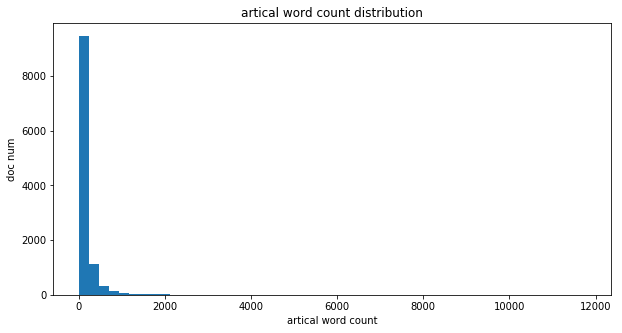

In [15]:
describe_data('artical word count', doc_word_count)

artical char count min: 12
artical char count max: 74932
artical char count 25 percent: 261.0
artical char count 50 percent: 526.0
artical char count 90 percent: 2039.7000000000007
artical char count 95 percent: 3429.7000000000007


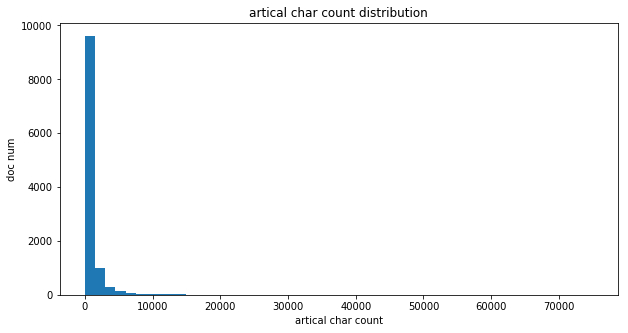

In [16]:
describe_data('artical char count', doc_char_count)

# 传统机器学习模型

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## BoW特征提取

In [23]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.95, max_features=None)
X_train_vec = count_vect.fit_transform(X_train)

In [19]:
print(X_train_vec.shape)
print(count_vect.transform([X_train[0]])[0])

(11314, 25636)
  (0, 1365)	1
  (0, 1535)	1
  (0, 2340)	1
  (0, 4345)	1
  (0, 4722)	1
  (0, 4912)	1
  (0, 5026)	5
  (0, 7160)	1
  (0, 8210)	1
  (0, 8211)	1
  (0, 8494)	1
  (0, 8898)	1
  (0, 8923)	1
  (0, 10392)	1
  (0, 11628)	1
  (0, 12432)	1
  (0, 13542)	1
  (0, 13759)	1
  (0, 14259)	1
  (0, 14260)	1
  (0, 14511)	1
  (0, 15356)	1
  (0, 18215)	1
  (0, 18948)	1
  (0, 19576)	1
  (0, 20303)	1
  (0, 20658)	1
  (0, 21233)	1
  (0, 21544)	1
  (0, 21649)	1
  (0, 25060)	1
  (0, 25470)	1


In [20]:
print('id: 2705 feature name: {}'.format(count_vect.get_feature_names()[2705]))

print('id: 8155 feature name: {}'.format(count_vect.get_feature_names()[8155]))

id: 2705 feature name: allied
id: 8155 feature name: dogan


In [21]:
print('vocabulary size: {}'.format(len(count_vect.vocabulary_)))
print('stop word size: {}'.format(len(count_vect.stop_words_)))
print('sample vocabulary: {}'.format(list(count_vect.vocabulary_)[:100]))
print('sample stop words: {}'.format(list(count_vect.stop_words_)[:100]))

vocabulary size: 25636
stop word size: 63056
sample vocabulary: ['car', 'wondering', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked', 'late', '60s', 'early', '70s', 'called', 'doors', 'really', 'small', 'addition', 'bumper', 'separate', 'rest', 'body', 'know', 'model', 'engine', 'specs', 'years', 'production', 'history', 'info', 'funky', 'looking', 'mail', 'si', 'clock', 'poll', 'final', 'fair', 'number', 'brave', 'souls', 'upgraded', 'oscillator', 'shared', 'experiences', 'send', 'brief', 'message', 'detailing', 'procedure', 'speed', 'attained', 'cpu', 'rated', 'add', 'cards', 'adapters', 'heat', 'sinks', 'hour', 'usage', 'floppy', 'disk', 'functionality', '800', 'floppies', 'especially', 'requested', 'summarizing', 'days', 'network', 'knowledge', 'base', 'upgrade', 'haven', 'answered', 'thanks', 'pb', 'questions', 'folks', 'mac', 'plus', 'finally', 'gave', 'ghost', 'weekend', 'starting', 'life', '512k', 'way', '1985', 'sooo', 'market', 'new', 'machine', 'bit', 'sooner', 'intend

## TFIDF特征

In [22]:
tfidf_transformer = TfidfTransformer()

# 基于整个训练集，提取TFIDF特征
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)

X_train_dev_tfidf = tfidf_transformer.transform(count_vect.transform(X_train_dev))
X_val_tfidf = tfidf_transformer.transform(count_vect.transform(X_val))
X_test_tfidf = tfidf_transformer.transform(count_vect.transform(X_test))

In [23]:
print(X_train_tfidf.shape)
print(X_train_tfidf[0])

(11314, 25636)
  (0, 25470)	0.0935990275764
  (0, 25060)	0.139797192887
  (0, 21649)	0.164625642866
  (0, 21544)	0.160931591391
  (0, 21233)	0.114228579665
  (0, 20658)	0.1471779418
  (0, 20303)	0.128309084298
  (0, 19576)	0.122924846566
  (0, 18948)	0.0898028127685
  (0, 18215)	0.161987583731
  (0, 15356)	0.131237349763
  (0, 14511)	0.101811121618
  (0, 14260)	0.106089862662
  (0, 14259)	0.136819093622
  (0, 13759)	0.13917463675
  (0, 13542)	0.0705685577069
  (0, 12432)	0.113507348505
  (0, 11628)	0.125115025305
  (0, 10392)	0.225840786829
  (0, 8923)	0.207178247221
  (0, 8898)	0.144424149927
  (0, 8494)	0.127599173216
  (0, 8211)	0.174003575375
  (0, 8210)	0.149333039944
  (0, 7160)	0.105955128335
  (0, 5026)	0.581918389045
  (0, 4912)	0.106820059369
  (0, 4722)	0.197575005001
  (0, 4345)	0.130336032017
  (0, 2340)	0.141587386174
  (0, 1535)	0.207178247221
  (0, 1365)	0.209173556448


## 初始模型评估

In [15]:
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    results = {}
    start = time()
    
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()
    results['pred_time'] = end - start
    
    results['name'] = learner.__class__.__name__
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_val'] = accuracy_score(y_val, predictions_val)

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))

    return results


In [16]:
def model_metrics(results, title, bar_width=0.2, group_width=0.6, metrics=(('train_time', 'pred_time'), ('acc_train', 'acc_val'))):
    fig, ax = plt.subplots(1, 2, figsize = (16,5))
    learner_count = len(results)
    
    for k, learner in enumerate(results.keys()):
        for i in range(2):
            ax[i].bar(k*group_width, results[learner][metrics[i][0]], width = bar_width, color='green', label=metrics[i][0])
            ax[i].text(k*group_width, results[learner][metrics[i][0]]+0.01, '%.2f' % (results[learner][metrics[i][0]]), ha='center', va= 'bottom')
            ax[i].bar(k*group_width+bar_width, results[learner][metrics[i][1]], width = bar_width, color='red', label=metrics[i][1])
            ax[i].text(k*group_width+bar_width, results[learner][metrics[i][1]]+0.01, '%.2f' % (results[learner][metrics[i][1]]), ha='center', va= 'bottom')

    ax[0].set_xticks(np.arange(bar_width/2, learner_count*group_width+bar_width/2, group_width))
    ax[0].set_xticklabels(results.keys())
    ax[0].set_xlabel("Model")
    ax[0].legend(loc='best')
    ax[0].set_xlim((-0.1, learner_count*group_width+bar_width))

    ax[1].set_xticks(np.arange(bar_width/2, learner_count*group_width+bar_width/2, group_width))
    ax[1].set_xticklabels(results.keys())
    ax[1].set_xlabel("Model")
    ax[1].legend(loc='best')
    ax[1].set_xlim((-0.1, learner_count*group_width+bar_width))
    
    # Add unique y-labels
    ax[0].set_ylabel("Time (in seconds)")
    ax[1].set_ylabel("Accuracy Score")
    
    # Add titles
    ax[0].set_title("Model Time")
    ax[1].set_title("Accuracy Score")
    
    # Set y-limits for score panels
    #ax[1].set_ylim((0, 1))

    plt.suptitle(title, fontsize = 16, y = 1.10)
    #plt.tight_layout()
    plt.show()

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [27]:
base_results = {}

In [28]:
tree = DecisionTreeClassifier(random_state=0)
base_results['DecisionTree'] = train_predict(tree, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['DecisionTree'])

DecisionTreeClassifier trained on 9051 samples.
{'acc_train': 0.99889514970721471,
 'acc_val': 0.64692885550154666,
 'name': 'DecisionTreeClassifier',
 'pred_time': 0.04399538040161133,
 'train_time': 13.70462942123413}


In [29]:
mnb = MultinomialNB()
base_results['NaiveBayes'] = train_predict(mnb, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['NaiveBayes'])

MultinomialNB trained on 9051 samples.
{'acc_train': 0.929289581261739,
 'acc_val': 0.84003535130357931,
 'name': 'MultinomialNB',
 'pred_time': 0.0679934024810791,
 'train_time': 0.10898923873901367}


In [30]:
svm = LinearSVC(random_state=0)
base_results['SVM'] = train_predict(svm, X_train_dev_tfidf.shape[0], X_train_dev_tfidf, y_train_dev, X_val_tfidf, y_val)
pprint(base_results['SVM'])

LinearSVC trained on 9051 samples.
{'acc_train': 0.99701690420947964,
 'acc_val': 0.8877596111356606,
 'name': 'LinearSVC',
 'pred_time': 0.03499650955200195,
 'train_time': 1.858813762664795}


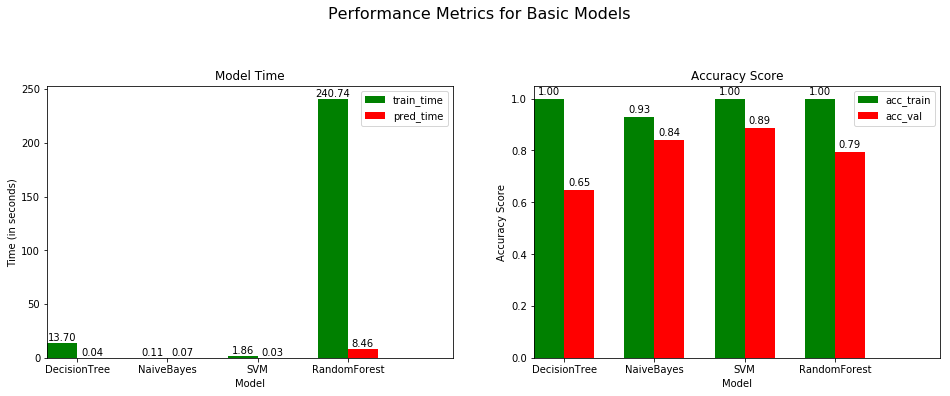

In [32]:
model_metrics(base_results, 'Performance Metrics for Basic Models')

## 模型调优

使用grid search寻找最优参数。

In [ ]:
from sklearn.model_selection import GridSearchCV
def grid_search_cv(classifier, parameters, X_train, y_train):
    '''
    return metrics for the best model
    '''
    results = {}
    search = GridSearchCV(classifier(), parameters, cv=5, n_jobs=cpu_count()-1, return_train_score=True)

    search.fit(X_train, y_train)

    print('GridSearch for {}'.format(classifier.__name__))
    print('best params: {}'.format(search.best_params_))
    print('best score: {}'.format(search.best_score_))
    
    results['name'] = classifier.__name__
    results['search'] = search
    results['mean_train_time'] = np.mean(search.cv_results_['mean_fit_time'])
    results['mean_pred_time'] = np.mean(search.cv_results_['mean_score_time'])
    results['best_acc_train'] = search.cv_results_['mean_train_score'][search.best_index_]
    results['best_acc_val'] = search.cv_results_['mean_test_score'][search.best_index_]

    return results

In [33]:
improve_results = {}

In [34]:
parameters = {'max_depth': [10, 50, 100, 200, 500], 'min_samples_leaf': [2, 5, 10, 20, 50]}
improve_results['DecisionTree'] = grid_search_cv(DecisionTreeClassifier, parameters, X_train_tfidf, y_train)

GridSearch for DecisionTreeClassifier
best params: {'max_depth': 500, 'min_samples_leaf': 2}
best score: 0.614725119321195


In [35]:
parameters = {'alpha': [.0001, .001, .01, .02, .03, .04, .05, .06, .1, .3, .5, .8]}
improve_results['NaiveBayes'] = grid_search_cv(MultinomialNB, parameters, X_train_tfidf, y_train)

GridSearch for MultinomialNB
best params: {'alpha': 0.04}
best score: 0.8706911790701786


In [36]:
parameters = {'C': [.1, .3, .5, .8, 1.0]}
improve_results['SVM'] = grid_search_cv(LinearSVC, parameters, X_train_tfidf, y_train)

GridSearch for LinearSVC
best params: {'C': 0.8}
best score: 0.88103234930175


In [37]:
with open('improve_results.pkz', 'wb') as fp:
    pickle.dump(improve_results, fp)

In [38]:
if os.path.isfile('improve_results.pkz'):
    with open('improve_results.pkz', 'rb') as fp:
        improve_results = pickle.load(fp)

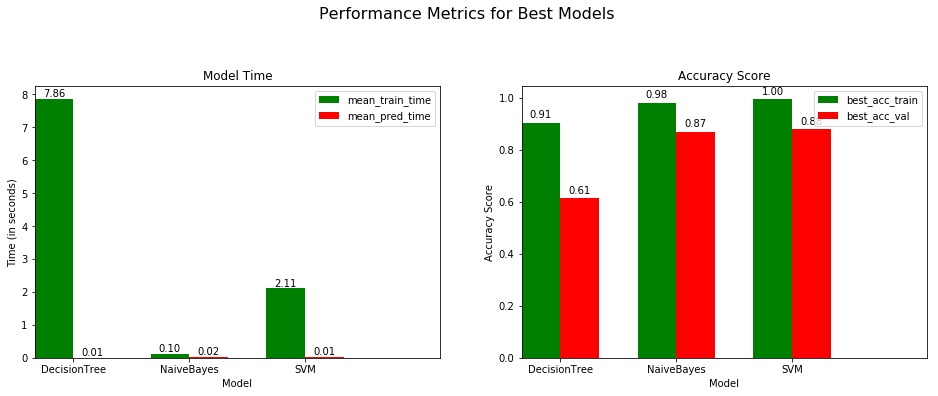

In [39]:
model_metrics(improve_results, 'Performance Metrics for Best Models',
              metrics=(('mean_train_time', 'mean_pred_time'), ('best_acc_train', 'best_acc_val')))

### 在测试集上的表现

In [40]:
model_names = ['DecisionTree', 'NaiveBayes', 'SVM']
for model_name in model_names:
    if model_name not in improve_results:
        continue
    print('{} test set acc: {}'.format(model_name, improve_results[model_name]['search'].best_estimator_.score(X_test_tfidf, y_test)))

DecisionTree test set acc: 0.5406266595857674
NaiveBayes test set acc: 0.7837227827934148
SVM test set acc: 0.7869091874668083


### 基于最优模型的最优参数进一步调参

In [8]:
from sklearn.pipeline import make_pipeline

In [27]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

punctuation_set = set(r',<.>/?;:\'"[{]}\|`~-_=+!@#$%^&*()')

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in punctuation_set]
    
class StemmerTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in punctuation_set]


In [37]:
pipeline_raw = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, ngram_range=(1,2)),
                        TfidfTransformer(),
                        MultinomialNB(alpha=0.04))
print(train_predict(pipeline, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 82.76827621459961, 'pred_time': 147.26672506332397, 'name': 'Pipeline', 'acc_train': 0.97003712214954918, 'acc_val': 0.77920870950610732}


In [22]:
pipeline_lemma = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, tokenizer=LemmaTokenizer()),
                        TfidfTransformer(),
                        MultinomialNB(alpha=0.04))
print(train_predict(pipeline, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 41.592000007629395, 'pred_time': 66.22899985313416, 'name': 'Pipeline', 'acc_train': 0.97604737493371041, 'acc_val': 0.77907594264471591}


In [28]:
pipeline_stemmer = make_pipeline(CountVectorizer(stop_words='english', min_df=3, max_df=0.95, tokenizer=StemmerTokenizer()),
                        TfidfTransformer(),
                        MultinomialNB(alpha=0.04))
print(train_predict(pipeline, len(X_train), X_train, y_train, X_test, y_test))

Pipeline trained on 11314 samples.
{'train_time': 88.96980309486389, 'pred_time': 131.66370272636414, 'name': 'Pipeline', 'acc_train': 0.97003712214954918, 'acc_val': 0.77920870950610732}


# 模型分析

In [66]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(grid_obj.best_estimator_, count_vect, newsgroups_target_names)

alt.atheism: don islam morality writes people atheism keith atheists edu god
comp.graphics: polygon images program file edu thanks 3d files image graphics
comp.os.ms-windows.misc: ms use card drivers driver files edu dos file windows
comp.sys.ibm.pc.hardware: dos disk thanks pc controller bus ide card drive scsi
comp.sys.mac.hardware: thanks duo simms monitor centris quadra edu drive apple mac
comp.windows.x: program com thanks application xterm x11r5 widget server motif window
misc.forsale: mail forsale price edu condition new shipping offer 00 sale
rec.autos: dealer just article oil writes engine edu com cars car
rec.motorcycles: bmw writes edu article motorcycle bikes ride com dod bike
rec.sport.baseball: pitching writes runs games players game team year edu baseball
rec.sport.hockey: games edu season players ca play nhl game team hockey
sci.crypt: com nsa crypto escrow government keys chip encryption clipper key
sci.electronics: need radar phone com does know power circuit use edu


In [ ]:
from sklearn import metrics

predicted = mnb.predict(X_val_tfidf)
print(metrics.classification_report(y_val, predicted, target_names=newsgroups_all.target_names))

In [ ]:
metrics.confusion_matrix(y_val, predicted)

# 深度模型

## 词向量word2vec

In [65]:
import gensim
from gensim.models import word2vec

EMBEDDING_DIM = 100

In [40]:
if not os.path.isfile('word2vec/text8.model'):
    sentences = word2vec.Text8Corpus('word2vec/text8')
    wv_text8 = word2vec.Word2Vec(sentences, sg=0, size=EMBEDDING_DIM, workers=4)
    wv_text8.save('word2vec/text8.model')
    print('word2vec model trained and saved')
else:
    wv_text8 = word2vec.Word2Vec.load('word2vec/text8.model')
    print('word2vec model loaded from disk')

word2vec model loaded from disk


In [72]:
def word2vec_accuracy(word_vector):
    word2vec_acc = word_vector.accuracy('word2vec/questions-words.txt')
    section_acc = {}
    total_correct = 0
    total_incorrect = 0
    for section in word2vec_acc:
        correct = len(section['correct'])
        incorrect = len(section['incorrect'])
        section_acc[section['section']] = float(correct) / (correct + incorrect)
        total_correct += correct
        total_incorrect += incorrect
    section_acc['total'] = float(total_correct) / (total_correct + total_incorrect)
    return section_acc

In [108]:
def word2vec_min_max(word_vector):
    cur_min = float('inf')
    cur_max = -float('inf')
    for key in word_vector.vocab:
        for value in word_vector[key]:
            if value > cur_max:
                cur_max = value
            if value < cur_min:
                cur_min = value
    return cur_min, cur_max

In [109]:
word2vec_min_max(wv_text8.wv)

(-5.1268196, 5.4787431)

In [73]:
print(word2vec_accuracy(wv_text8.wv))

{'capital-common-countries': 0.36363636363636365, 'capital-world': 0.18663911845730027, 'currency': 0.11194029850746269, 'city-in-state': 0.10502864417568428, 'family': 0.7777777777777778, 'gram1-adjective-to-adverb': 0.12566137566137567, 'gram2-opposite': 0.1437908496732026, 'gram3-comparative': 0.6039682539682539, 'gram4-superlative': 0.3675889328063241, 'gram5-present-participle': 0.30544354838709675, 'gram6-nationality-adjective': 0.524434719183078, 'gram7-past-tense': 0.2605105105105105, 'gram8-plural': 0.4415322580645161, 'gram9-plural-verbs': 0.33692307692307694, 'total': 0.32605151613955}


In [62]:
print(wv_text8.wv.evaluate_word_pairs('word2vec/wordsim353.tsv'))

((0.60493981974836086, 2.0733695480321427e-36), SpearmanrResult(correlation=0.6199870461537087, pvalue=1.1761399634390484e-38), 0.56657223796034)


## 词向量Glovec 预训练

In [67]:
from gensim.scripts.glove2word2vec import glove2word2vec

if not os.path.isfile('word2vec/glove2word2vec.6B.100d.txt'):
    glove2word2vec('word2vec/glove.6B.100d.txt', 'word2vec/glove2word2vec.6B.100d.txt')

wv_glove = gensim.models.KeyedVectors.load_word2vec_format('word2vec/glove2word2vec.6B.100d.txt',binary=False)

In [110]:
word2vec_min_max(wv_glove.wv)

(-4.0665998, 3.575)

In [68]:
print(word2vec_accuracy(wv_glove.wv))

{'capital-common-countries': 0.9426877470355731, 'capital-world': 0.8939226519337017, 'currency': 0.17796610169491525, 'city-in-state': 0.31230140717203814, 'family': 0.8771929824561403, 'gram1-adjective-to-adverb': 0.2206896551724138, 'gram2-opposite': 0.23421052631578948, 'gram3-comparative': 0.7935435435435435, 'gram4-superlative': 0.5983333333333334, 'gram5-present-participle': 0.6946236559139785, 'gram6-nationality-adjective': 0.9487889273356401, 'gram7-past-tense': 0.5544871794871795, 'gram8-plural': 0.7793560606060606, 'gram9-plural-verbs': 0.5797720797720798, 'total': 0.6549035423808564}


In [69]:
print(wv_glove.wv.evaluate_word_pairs('word2vec/wordsim353.tsv'))

((0.5483502271903985, 4.2350974945224685e-29), SpearmanrResult(correlation=0.53273543232382736, pvalue=2.8654146580558905e-27), 0.0)


In [74]:
def load_glove():
    embeddings_index = {}
    f = open('word2vec/glove.6B.100d.txt', encoding='utf8')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


# 深度模型

In [192]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten, Merge
from keras.layers import Conv1D, Convolution1D, Activation, MaxPooling1D, MaxPool1D, GRU, Embedding, LSTM
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [82]:
class FixLengthTokenizer():
    '''
    tokenize doc and padding to fix length
    '''
    def __init__(self, num_words, maxlen):
        self.tokenizer = Tokenizer(num_words=num_words)
        self.word_index = {}
        self.is_fitted = False
        self.maxlen = maxlen
    
    def fit(self, raw_documents):
        self.tokenizer.fit_on_texts(raw_documents)
        self.word_index = self.tokenizer.word_index
        self.is_fitted = True
    
    def transform(self, raw_documents):
        if not self.is_fitted:
            raise Exception('tokenizer not fitted yet')
        return pad_sequences(self.tokenizer.texts_to_sequences(raw_documents), maxlen=self.maxlen)

In [181]:
print('Processing text dataset')

vectorizer = FixLengthTokenizer(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
vectorizer.fit(X_train)

print('Found %s unique tokens.' % len(vectorizer.word_index))

X_train_dl = vectorizer.transform(X_train_dev)
y_train_dl = to_categorical(np.asarray(y_train_dev), num_classes=20)

X_val_dl = vectorizer.transform(X_val)
y_val_dl = to_categorical(np.asarray(y_val), num_classes=20)

X_test_dl = vectorizer.transform(X_test)
y_test_dl = to_categorical(np.asarray(y_test), num_classes=20)

print('Shape of train data tensor:', X_train_dl.shape)
print('Shape of train label tensor:', y_train_dl.shape)

Processing text dataset
Found 91983 unique tokens.
Shape of train data tensor: (9051, 1000)
Shape of train label tensor: (9051, 20)


In [157]:
def build_embedding_matrix(word_vector, word_index, num_words, embedding_dim, random_initialize=False):
    # no word idx 0, embedding size num_words+1
    embedding_matrix = np.zeros((num_words+1, embedding_dim))

    for word, i in word_index.items():
        if i > num_words:
            continue
        if word in word_vector:
            embedding_matrix[i] = word_vector[word]
        else:
            if random_initialize:
                embedding_matrix[i] = np.random.uniform(-5, 5, embedding_dim)
    
    return embedding_matrix

In [163]:
# Preparing embedding matrix

num_words = min(MAX_NUM_WORDS, len(vectorizer.word_index))

embedding_matrix = build_embedding_matrix(wv_glove.wv, vectorizer.word_index, num_words, EMBEDDING_DIM, True)

print('embedding matrix shape: {}'.format(embedding_matrix.shape))

embedding matrix shape: (20001, 100)


In [179]:
def plot_keras_history(history):
    fig, ax = plt.subplots(1, 2, figsize = (16,5))
    ax[0].plot(range(1, len(history['acc']) + 1), history['acc'], label='train')
    ax[0].plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='val')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc='best')
    ax[0].set_title('Train acc')
    ax[0].set_xticks(range(1, len(history['acc']) + 1))
    ax[0].set_ylim((0, 1))

    ax[1].plot(range(1, len(history['loss']) + 1), history['loss'], label='train')
    ax[1].plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='val')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc='best')
    ax[1].set_title('Train loss')
    ax[1].set_xticks(range(1, len(history['acc']) + 1))
    
    fig.show()

## TextCNN

In [117]:
def TextCNN(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    if embeddings is None:
        embedding_layer = Embedding(num_words+1,
                                embedding_dim,
                                input_length=max_sequence_length,
                                trainable=True)
    else:
        embedding_layer = Embedding(num_words+1,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #optional dropout
    x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [118]:
text_cnn = TextCNN(embedding_matrix, MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM, len(newsgroups_target_names), False)

D:\install\Continuum\anaconda3\envs\mlnd_capstone\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [119]:
text_cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    2000100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 998, 128)     38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 997, 128)     51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [120]:
history = text_cnn.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=60, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/3
9051/9051 [==============================] - 398s 44ms/step - loss: 3.3499 - acc: 0.0562 - val_loss: 2.9945 - val_acc: 0.0557
Epoch 2/3
9051/9051 [==============================] - 405s 45ms/step - loss: 2.9810 - acc: 0.0654 - val_loss: 2.9645 - val_acc: 0.0809
Epoch 3/3
9051/9051 [==============================] - 393s 43ms/step - loss: 2.8904 - acc: 0.0987 - val_loss: 2.6886 - val_acc: 0.1547


D:\install\Continuum\anaconda3\envs\mlnd_capstone\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


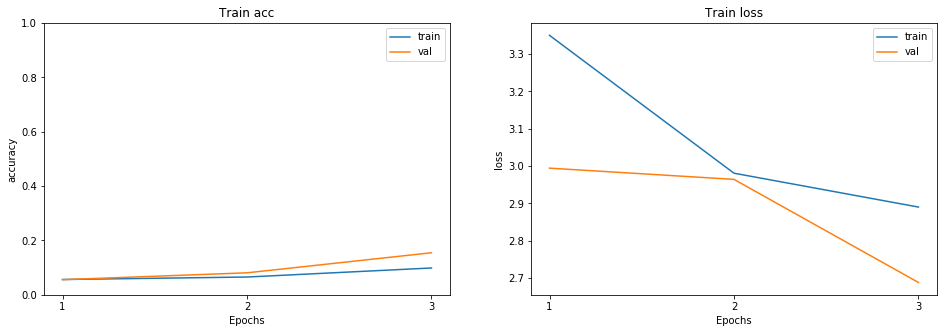

In [178]:
plot_keras_history(history.history)

In [63]:
score = text_cnn.evaluate(X_test_dl, y_test_dl, batch_size=128)

7532/7532 [==============================] - 2s 241us/step


In [64]:
print(text_cnn.metrics_names)
print(score)

['loss', 'acc']
[1.9921991821305269, 0.65772703095313023]


## LSTM

In [27]:
 def Lstm(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    model = Sequential()
    model.add(Embedding(num_words+1,
                        embedding_dim,
                        input_length=max_sequence_length,
                        trainable=True))
    model.add(Convolution1D(256, 3, padding='same', strides = 1))
    model.add(Activation('relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1, return_sequences = True))
    model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1))
    model.add(Dense(labels_index, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [28]:
lstm = Lstm(embedding_matrix, MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM, len(newsgroups_target_names))

In [67]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 1000, 256)         77056     
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 256)         0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 500, 256)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 256)          393984    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_13 (Dense)             (None, 20)                5140      
Total para

In [29]:
history = lstm.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=20, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 107s 12ms/step - loss: 2.8523 - acc: 0.0914 - val_loss: 2.3880 - val_acc: 0.1922
Epoch 2/10
9051/9051 [==============================] - 97s 11ms/step - loss: 2.0140 - acc: 0.2870 - val_loss: 1.6974 - val_acc: 0.3862
Epoch 3/10
9051/9051 [==============================] - 98s 11ms/step - loss: 1.1966 - acc: 0.5640 - val_loss: 1.2430 - val_acc: 0.5859
Epoch 4/10
9051/9051 [==============================] - 98s 11ms/step - loss: 0.6582 - acc: 0.7780 - val_loss: 1.0653 - val_acc: 0.6916
Epoch 5/10
9051/9051 [==============================] - 97s 11ms/step - loss: 0.3684 - acc: 0.8838 - val_loss: 1.0511 - val_acc: 0.7282
Epoch 6/10
9051/9051 [==============================] - 98s 11ms/step - loss: 0.2206 - acc: 0.9336 - val_loss: 0.9899 - val_acc: 0.7587
Epoch 7/10
9051/9051 [==============================] - 97s 11ms/step - loss: 0.1418 - acc: 0.9603 - val_loss: 0.9834 - val_acc: 0.7720

In [ ]:
plot_keras_history(history.history)

In [30]:
score = lstm.evaluate(X_test_dl, y_test_dl, batch_size=128)

7532/7532 [==============================] - 15s 2ms/step


In [31]:
print(lstm.metrics_names)
print(score)

['loss', 'acc']
[1.9153870939258812, 0.64126394134345233]


## char cnn

In [193]:
class CharVectorizer:
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}\n"

    def __init__(self, max_seq_length):
        self.char_map = {}
        self.max_seq_length = max_seq_length
        for i, c in enumerate(self.alphabet):
            if c in self.char_map:
                print('duplicated char: {}'.format(c))
            self.char_map[c] = i

    def transform(self, raw_documents):
        transformed_documents = np.zeros((len(raw_documents), self.max_seq_length, len(self.char_map)), dtype='bool')
        for i, document in enumerate(raw_documents):
            document = document.lower()[:self.max_seq_length]
            onehot = np.zeros((self.max_seq_length, len(self.char_map)), dtype='bool')
            for j, c in enumerate(reversed(document)):
                if c in self.char_map:
                    onehot[j][self.char_map[c]] = 1
            transformed_documents[i] = onehot

        return transformed_documents

In [194]:
MAX_CHAR_SEQUENCE_LENGTH = 3500
char_vectorizer = CharVectorizer(MAX_CHAR_SEQUENCE_LENGTH)

X_train_dl = char_vectorizer.transform(X_train_dev)
y_train_dl = to_categorical(np.asarray(y_train_dev), num_classes=20)

X_val_dl = char_vectorizer.transform(X_val)
y_val_dl = to_categorical(np.asarray(y_val), num_classes=20)

X_test_dl = char_vectorizer.transform(X_val)
y_test_dl = to_categorical(np.asarray(y_val), num_classes=20)

In [195]:
print('X_train shape:{}'.format(X_train_dl.shape))

X_train shape:(9051, 3500, 69)


In [34]:
def char_cnn(n_vocab, max_len, n_classes):

    "See Zhang and LeCun, 2015"

    model = Sequential()

    model.add(Conv1D(256, 7, activation='relu', input_shape=(max_len, n_vocab)))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(256, 7, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [35]:
char_model = char_cnn(len(alphabet), MAX_CHAR_SEQUENCE_LENGTH, len(newsgroups_target_names))

In [36]:
char_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3494, 256)         123904    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1164, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1158, 256)         459008    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 386, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 384, 256)          196864    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 382, 256)          196864    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 380, 256)          196864    
__________

In [37]:
history = char_model.fit(X_train_dl, y_train_dl, validation_data=(X_val_dl, y_val_dl), epochs=30, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 54s 6ms/step - loss: 2.9839 - acc: 0.0615 - val_loss: 2.9606 - val_acc: 0.0619
Epoch 2/30
9051/9051 [==============================] - 50s 6ms/step - loss: 2.9250 - acc: 0.0816 - val_loss: 2.8247 - val_acc: 0.1052
Epoch 3/30
9051/9051 [==============================] - 50s 6ms/step - loss: 2.7066 - acc: 0.1158 - val_loss: 2.6454 - val_acc: 0.1304
Epoch 4/30
9051/9051 [==============================] - 50s 6ms/step - loss: 2.5066 - acc: 0.1411 - val_loss: 2.4952 - val_acc: 0.1458
Epoch 5/30
9051/9051 [==============================] - 50s 6ms/step - loss: 2.3068 - acc: 0.1883 - val_loss: 2.4168 - val_acc: 0.1719
Epoch 6/30
9051/9051 [==============================] - 50s 6ms/step - loss: 2.0904 - acc: 0.2410 - val_loss: 2.1287 - val_acc: 0.2324
Epoch 7/30
9051/9051 [==============================] - 50s 6ms/step - loss: 1.8561 - acc: 0.3069 - val_loss: 2.0539 - val_acc: 0.2749
Epoch 8

In [ ]:
plot_keras_history(history.history)

In [38]:
score = char_model.evaluate(X_test_dl, y_test_dl, batch_size=128)

2263/2263 [==============================] - 5s 2ms/step


In [39]:
print(char_model.metrics_names)
print(score)

['loss', 'acc']
[3.0544149517433548, 0.48210340320826944]
